In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Custom Data Generator Loop (NAICS only)
Loop through fill rates with a custom generator, to see how the performance varies.

Base NAICS only, and data with no missing values

*This script takes about 8 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib.ticker as ticker

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model, sbnn_plot
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

In [8]:
sbnn_plot.plot_defaults()

## Input Data

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [12]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [13]:
# NAICS feature
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [14]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [15]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [16]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 11), y:(446848,)


In [17]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 11), y:(95604,)


In [18]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

## Loop for different fits

In [19]:
def gen_fit_loop(rate = 0.1):
    this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)
    generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = rate,
                               injection_value = 1)
    callback = keras.callbacks.EarlyStopping(patience=3)
    
    # Fit - vary rate
    this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                             callbacks=[callback])
    this_history_df = sbnn_model.process_history(this_history)
    this_history_df['rate'] = rate
    
    # Predictions then metrics
    this_predict = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])
    this_predict_df = pd.DataFrame(this_predict, index=X.index) \
        .set_axis(['predict_prob'], axis=1) \
        .reset_index() \
        .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
               on='LoanNr_ChkDgt')
    
    # Threshold tune
    this_pred_train = this_predict_df[this_predict_df['dset'] == 'train']
    thresh_tune_data = sbnn_metrics.get_f1_frame(this_pred_train['target'], 
                                        this_pred_train['predict_prob'])
    thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
    best_thresh = thresh_tune_data['thresh'].iloc[0]
    this_predict_df['predict_bin'] = sbnn_metrics.get_binary_predictions(this_predict_df['predict_prob'], 
                                                                            best_thresh)
    
    this_metrics_dset = this_predict_df.groupby('dset') \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics_test = this_predict_df[this_predict_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics = pd.concat([this_metrics_dset, this_metrics_test])
    this_metrics['rate'] = rate
    this_metrics['thresh'] = best_thresh
    
    return this_history_df, this_metrics


## Run Loop

In [20]:
rate_vals = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]

In [21]:
history = pd.DataFrame()
metrics = pd.DataFrame()

In [22]:
%%capture
for r in rate_vals:
    this_hist, this_met = gen_fit_loop(r)
    history = pd.concat([history, this_hist])
    metrics = pd.concat([metrics, this_met])

2024-05-21 06:20:38.429727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-21 06:20:38.429753: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-21 06:20:38.429759: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-21 06:20:38.429984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-21 06:20:38.430007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-21 06:20:39.130456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-21 06:23:14.154315: I t

In [23]:
history['epoch'] = history.groupby('rate').cumcount()
history.to_csv(Path(setup.temp_path).joinpath('14_REPORT_loop_history.csv'))

In [24]:
metrics.to_csv(Path(setup.temp_path).joinpath('14_REPORT_loop_metrics.csv'))

In [25]:
metrics[metrics['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
0,test,0.652961,0.446968,0.330489,0.690240,0.380069,0.726907,0.0,0.0000,0.20
0,test,0.656906,0.447701,0.332649,0.684419,0.377593,0.725895,0.0,0.0010,0.22
0,test,0.643679,0.448412,0.327079,0.712851,0.379090,0.726423,0.0,0.0050,0.18
0,test,0.662809,0.445889,0.334693,0.667731,0.378000,0.725429,0.0,0.0100,0.20
0,test,0.672740,0.448057,0.340816,0.653773,0.382422,0.727458,0.0,0.0500,0.24
0,test,0.655002,0.448685,0.332202,0.690961,0.380207,0.727672,0.0,0.1000,0.22
0,test,0.667853,0.447777,0.338098,0.662787,0.378292,0.726669,0.0,0.3000,0.24
0,test,0.647927,0.444221,0.326986,0.692506,0.378599,0.724155,0.0,0.5000,0.24
0,test,0.651203,0.446805,0.329619,0.693278,0.379345,0.726135,0.0,0.7000,0.22
0,test,0.663018,0.445203,0.334490,0.665465,0.377620,0.724823,0.0,0.8000,0.22


In [26]:
metrics[metrics['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
1,test,0.507627,0.417611,0.273204,0.885834,0.344380,0.713915,1.0,0.0000,0.20
1,test,0.620236,0.436815,0.310033,0.739024,0.347092,0.715734,1.0,0.0010,0.22
1,test,0.631125,0.434133,0.312644,0.710046,0.350885,0.717868,1.0,0.0050,0.18
1,test,0.675375,0.435020,0.333009,0.627128,0.351416,0.718444,1.0,0.0100,0.20
1,test,0.657738,0.435170,0.324209,0.661604,0.353673,0.719941,1.0,0.0500,0.24
1,test,0.634865,0.439017,0.316373,0.716942,0.351966,0.720567,1.0,0.1000,0.22
1,test,0.654520,0.439465,0.324728,0.679585,0.351759,0.719678,1.0,0.3000,0.24
1,test,0.638883,0.439301,0.318068,0.709872,0.353156,0.720222,1.0,0.5000,0.24
1,test,0.635769,0.438154,0.316313,0.712665,0.353881,0.721486,1.0,0.7000,0.22
1,test,0.649423,0.437498,0.321572,0.684123,0.352707,0.720243,1.0,0.8000,0.22


## Plots

In [42]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

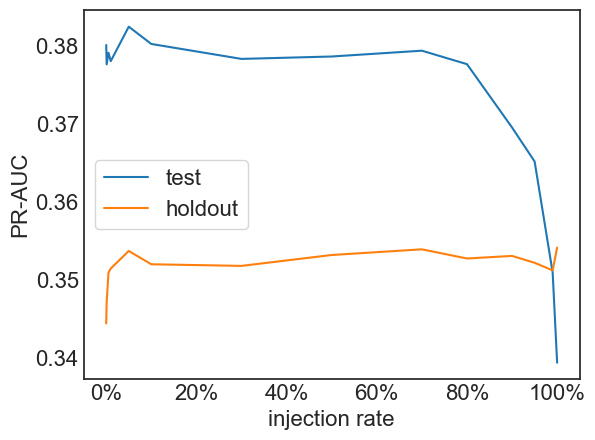

In [43]:
fig = sbnn_plot.plot_metric_dependence(metrics, xformatter = ticker.PercentFormatter(1),
                                      ylabel='PR-AUC',
                            xlabel='injection rate')
fig.savefig(Path(setup.temp_path).joinpath('14_PLOT_average_precision.png'),
            bbox_inches='tight')

##### History

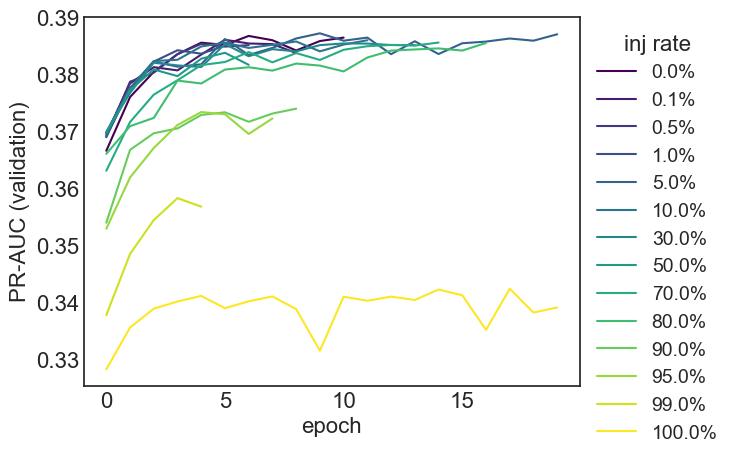

In [44]:
fig = sbnn_plot.plot_history_group(history,
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'PR-AUC (validation)',
                                  leg_title='inj rate')
fig.savefig(Path(setup.temp_path).joinpath('14_PLOT_hostory_val_auc.png'),
            bbox_inches='tight')

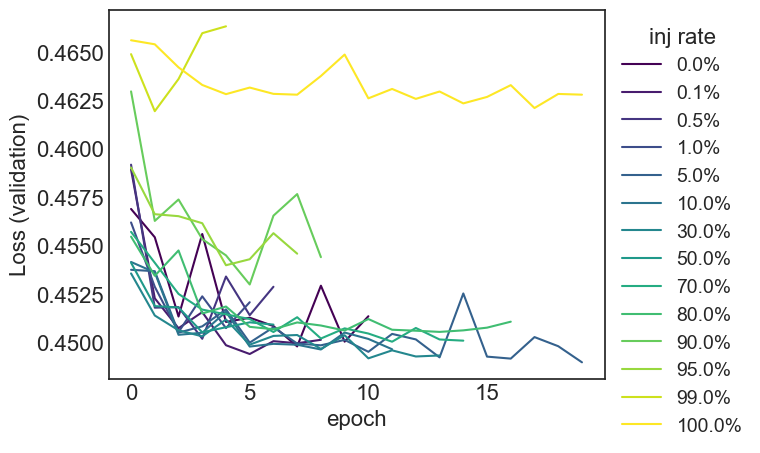

In [46]:
fig = sbnn_plot.plot_history_group(history, 'val_loss',
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'Loss (validation)',
                                  leg_title='inj rate')
fig.savefig(Path(setup.temp_path).joinpath('14_PLOT_hostory_val_loss.png'),
            bbox_inches='tight')

## Max epochs

In [49]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

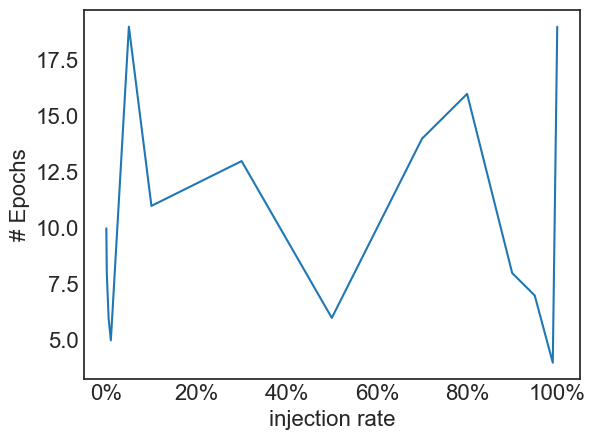

In [51]:
fig = sbnn_plot.plot_epoch_agg(history,
                               xformatter = ticker.PercentFormatter(1),
                               ylabel='# Epochs',
                               xlabel='injection rate')
fig.savefig(Path(setup.temp_path).joinpath('14_PLOT_hostory_epochs.png'),
            bbox_inches='tight')